Training



Number of NN parameters: 278368


Training Epochs:   0%|          | 1/500 [00:01<12:51,  1.55s/it]

Epoch 0, Average Loss: 231.2551


Training Epochs:  10%|█         | 51/500 [01:19<11:02,  1.48s/it]

Epoch 50, Average Loss: 36.2315


Training Epochs:  20%|██        | 101/500 [02:34<09:41,  1.46s/it]

Epoch 100, Average Loss: 30.1615


Training Epochs:  30%|███       | 151/500 [03:50<08:26,  1.45s/it]

Epoch 150, Average Loss: 25.2115


Training Epochs:  40%|████      | 201/500 [05:06<07:22,  1.48s/it]

Epoch 200, Average Loss: 23.5552


Training Epochs:  50%|█████     | 251/500 [06:23<06:36,  1.59s/it]

Epoch 250, Average Loss: 25.6509


Training Epochs:  60%|██████    | 301/500 [07:38<05:03,  1.52s/it]

Epoch 300, Average Loss: 24.1335


Training Epochs:  70%|███████   | 351/500 [08:53<03:42,  1.50s/it]

Epoch 350, Average Loss: 23.7648


Training Epochs:  80%|████████  | 401/500 [10:08<02:23,  1.45s/it]

Epoch 400, Average Loss: 23.8534


Training Epochs:  90%|█████████ | 451/500 [11:23<01:10,  1.44s/it]

Epoch 450, Average Loss: 22.0270


Training Epochs: 100%|██████████| 500/500 [12:36<00:00,  1.51s/it]


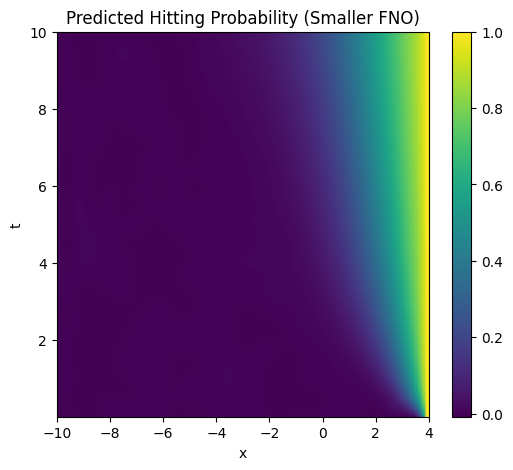

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt

############################################
# Common Drift Generation Function
############################################
def generate_drift(T_vals, T):
    """
    Generates a drift function u(t) using either a single sine wave
    or a sum of two sine waves with equal probability.
    """
    if np.random.rand() < 0.5:
        # Single sine wave
        A = np.random.uniform(-1, 1)
        freq = np.random.uniform(0.5, 2)
        phi = np.random.uniform(0, 2*np.pi)
        u = A * np.sin(2*np.pi * freq * T_vals/T + phi)
    else:
        # Sum of two sine waves
        A1 = np.random.uniform(-1, 1)
        freq1 = np.random.uniform(0.5, 2)
        phi1 = np.random.uniform(0, 2*np.pi)
        A2 = np.random.uniform(-1, 1)
        freq2 = np.random.uniform(0.5, 2)
        phi2 = np.random.uniform(0, 2*np.pi)
        u = A1 * np.sin(2*np.pi * freq1 * T_vals/T + phi1) + \
            A2 * np.sin(2*np.pi * freq2 * T_vals/T + phi2)
    return u

############################################
# Neural Operator Components
############################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along t dimension
        self.modes2 = modes2  # Fourier modes along x dimension
        self.scale = 1 / (in_channels * out_channels)
        # Learned complex weights
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # input: (batch, in_channels, t, x)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class NeuralOperatorControlPointNet(nn.Module):
    def __init__(self, modes1, modes2, width, n_cp_t, n_cp_x, n_layers=3):  # reduced layers to 3
        super(NeuralOperatorControlPointNet, self).__init__()
        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x
        # Lifting: from 1 channel to width channels
        self.fc0 = nn.Linear(1, width)
        # Fourier layers: alternating spectral conv and 1x1 conv
        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))
        # Final projection layers to output the inner control points (flattened)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, (n_cp_t - 1) * (n_cp_x - 1))

    def forward(self, x):
        # x shape: (batch, 1, grid_t, grid_x)
        x = x.permute(0, 2, 3, 1)   # (batch, grid_t, grid_x, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)    # (batch, width, grid_t, grid_x)
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)
        # Global average pooling
        x = x.mean(dim=[2,3])
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.shape[0], self.n_cp_t - 1, self.n_cp_x - 1)
        return x

############################################
# B-spline Basis Functions
############################################
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsFun_derivative(i, d, t, Ln):
    if d==0:
        return 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else d/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else d/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) - b * BsFun(i+1, d-1, t, Ln)

def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d+i-2]-Ln[i-2])==0 else d*(d-1)/((Ln[d+i-2]-Ln[i-2])**2)
        b = 0 if (Ln[d+i-1]-Ln[i-1])==0 else 2*d*(d-1)/((Ln[d+i-1]-Ln[i-1])**2)
        c = 0 if (Ln[d+i]-Ln[i])==0 else d*(d-1)/((Ln[d+i]-Ln[i])**2)
        return a*BsFun(i, d-2, t, Ln) - b*BsFun(i+1, d-2, t, Ln) + c*BsFun(i+2, d-2, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    Bit_deriv = np.zeros((Ns, n_cp))
    Bit_sec_deriv = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_deriv[i,j] = BsFun_derivative(j+1, d, tk[i], Ln)
            Bit_sec_deriv[i,j] = BsFun_second_derivative(j+1, d, tk[i], Ln)
    return Bit_deriv, Bit_sec_deriv

def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_deriv, Bit_x_deriv, Bit_t_sec_deriv, Bit_x_sec_deriv):
    B_surface_t = torch.matmul(torch.matmul(Bit_t_deriv, U_full), Bit_x.T)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_deriv.T)
    B_surface_xx = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_sec_deriv.T)
    return B_surface_t, B_surface_x, B_surface_xx

############################################
# Ground Truth Calculation with Refined Time Grid
############################################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the hitting time probability for dynamics:
         dx_t = u(t) dt + dW_t,
    where u is a numpy array on the time grid T_vals.

    f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t)), with U(t)=∫₀ᵗ u(s) ds.
    F(x,T) is obtained by cumulative integration over T_vals.
    For x >= a, F(x,T)=1.
    """
    # Compute cumulative drift U(t)
    U = cumulative_trapezoid(u, T_vals, initial=0)
    # Create grids
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2)/(2*T_grid_mod))
    f[0, :] = 0
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Force F = 1 for x >= a
    ix = np.where(x_vals >= a)[0]
    F[:, ix] = 1.0
    return F

############################################
# Setup: Grids, Data Generation, and B-spline Bases
############################################
T = 10           # maximum time
a = 4.0          # fixed barrier
n_cp_t = 25      # control points in time
n_cp_x = 25      # control points in space
d = 3            # B-spline order

# Refined time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)  # 1001 points from 1e-4 to T
Nt = len(T_vals)

# Spatial grid
x_vals = np.linspace(-10, a, 101)      # 101 points from -10 to a
Nx = len(x_vals)

############################################
# Generate Training Samples Using Common Drift Function
############################################
num_samples = 10  # Adjust as needed for fair comparison
training_data = []
for _ in range(num_samples):
    # Generate drift u(t) using the same function as in testing
    u_np = generate_drift(T_vals, T)
    F_true = ground_truth(x_vals, T_vals, a, u_np)  # shape (Nt, Nx)

    # Spatial B-spline bases (using a uniform grid for x)
    tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
    Bit_x_deriv_np, Bit_x_sec_deriv_np = BsKnots_derivatives(n_cp_x, d, Nx, Ln_x, tk_x)
    Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)
    Bit_x_deriv = torch.tensor(Bit_x_deriv_np, dtype=torch.float32)
    Bit_x_sec_deriv = torch.tensor(Bit_x_sec_deriv_np, dtype=torch.float32)

    training_data.append({
        'u': u_np,
        'x': torch.tensor(x_vals, dtype=torch.float32),
        'F_true': torch.tensor(F_true, dtype=torch.float32),  # shape (Nt, Nx)
        'Bit_x': Bit_x,
        'Bit_x_deriv': Bit_x_deriv,
        'Bit_x_sec_deriv': Bit_x_sec_deriv
    })

# B-spline bases for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t_deriv_np, Bit_t_sec_deriv_np = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)
Bit_t_deriv = torch.tensor(Bit_t_deriv_np, dtype=torch.float32)
Bit_t_sec_deriv = torch.tensor(Bit_t_sec_deriv_np, dtype=torch.float32)

############################################
# Model, Optimizer, and Training Loop (Smaller FNO)
############################################
modes1 = 8
modes2 = 8
width = 32
model = NeuralOperatorControlPointNet(modes1, modes2, width, n_cp_t, n_cp_x, n_layers=3)

# # use the following for larger size model
# modes1 = 12
# modes2 = 12
# width = 64
# model = NeuralOperatorControlPointNet(modes1, modes2, width, n_cp_t, n_cp_x, n_layers=4)


optimizer = optim.Adam(model.parameters(), lr=0.001)
print('Number of NN parameters:', sum(p.numel() for p in model.parameters()))

epochs = 500
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    total_loss = 0.0
    for data in training_data:
        optimizer.zero_grad()
        u_np = data['u']                # shape (Nt,)
        F_true_tensor = data['F_true']    # shape (Nt, Nx)
        Bit_x = data['Bit_x']
        Bit_x_deriv = data['Bit_x_deriv']
        Bit_x_sec_deriv = data['Bit_x_sec_deriv']

        # Convert u to torch tensor (Nt,1) for proper broadcasting
        u_tensor = torch.tensor(u_np, dtype=torch.float32).unsqueeze(1)
        # Prepare input function: shape (1, 1, Nt, Nx)
        F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)
        # Predict inner control points from the neural operator
        U_pred = model(F_input)[0]  # shape: (n_cp_t-1, n_cp_x-1)

        # Construct full control points with boundary conditions
        U_full = torch.ones((n_cp_t, n_cp_x))
        U_full[0, :] = 0      # initial condition at t=0
        U_full[:, -1] = 1     # boundary condition at x = a
        U_full[1:, :-1] = U_pred

        # Compute B-spline surface (predicted hitting probability)
        B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
        B_surface_t, B_surface_x, B_surface_xx = compute_bspline_derivatives(
            U_full, Bit_t, Bit_x, Bit_t_deriv, Bit_x_deriv, Bit_t_sec_deriv, Bit_x_sec_deriv
        )

        # PDE residual: note u_tensor is broadcast along space
        pde_residual = B_surface_t - u_tensor * B_surface_x - 0.5 * B_surface_xx
        physics_loss = torch.norm(pde_residual)
        data_loss = torch.norm(B_surface - F_true_tensor)
        loss = physics_loss + 3 * data_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0:
        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

############################################
# Visualization: Display a Sample Prediction
############################################
sample = training_data[0]
u_np = sample['u']
F_true_tensor = sample['F_true']
u_tensor = torch.tensor(u_np, dtype=torch.float32).unsqueeze(1)
F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)
model.eval()
with torch.no_grad():
    U_pred = model(F_input)[0]
U_full = torch.ones((n_cp_t, n_cp_x))
U_full[0, :] = 0
U_full[:, -1] = 1
U_full[1:, :-1] = U_pred
B_surface = torch.matmul(torch.matmul(Bit_t, U_full), sample['Bit_x'].T)

plt.figure(figsize=(6,5))
plt.imshow(B_surface.detach().numpy(), aspect='auto', origin='lower',
           extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
plt.title("Predicted Hitting Probability (Smaller FNO)")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()


In [ ]:
# # Define the save path on Google Drive
# save_path = '/content/drive/MyDrive/FNO/Trained Models/bspline_small_10_sample_500_epoch.pth'

# # Save the model state dictionary
# torch.save(model.state_dict(), save_path)
# print("Model saved to", save_path)

Model saved to /content/drive/MyDrive/FNO/Trained Models/bspline_small_10_sample_500_epoch.pth


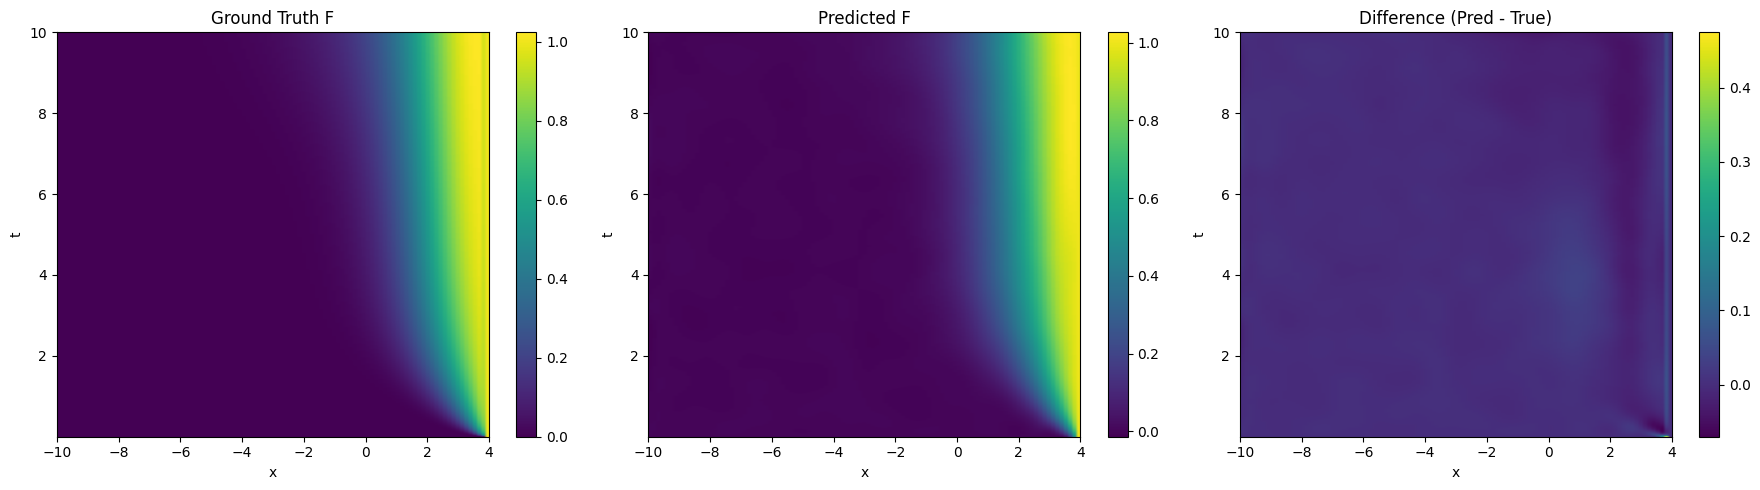

Test Results over 10 cases:
MSE:         Mean = 0.001736, Std = 0.003543
MAE:         Mean = 0.016641, Std = 0.016569
Relative Err: Mean = 0.084400, Std = 0.071824


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Lists to store error metrics for each test case
mse_list = []
mae_list = []
rel_error_list = []

num_tests = 10  # Number of test cases

# For testing, compute the spatial B-spline basis once (using the same parameters as training)
tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)

for i in range(num_tests):
    # Generate a test drift sample using the common function
    u_test = generate_drift(T_vals, T)

    # Compute the ground truth recovery probability for the test sample
    F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape (Nt, Nx)

    # Prepare the input tensor for the B-spline model: shape (1, 1, Nt, Nx)
    F_true_tensor = torch.tensor(F_true_test, dtype=torch.float32)
    F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)

    # Run the model in evaluation mode and obtain the inner control points
    model.eval()
    with torch.no_grad():
        U_pred = model(F_input)[0]  # shape (n_cp_t-1, n_cp_x-1)

    # Construct full control points with boundary conditions:
    #   - initial condition: U_full[0, :] = 0 (at t=0)
    #   - boundary condition: U_full[:, -1] = 1 (at x = a)
    U_full = torch.ones((n_cp_t, n_cp_x))
    U_full[0, :] = 0
    U_full[:, -1] = 1
    U_full[1:, :-1] = U_pred

    # Compute the predicted B-spline surface (hitting probability)
    B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
    F_pred = B_surface.detach().numpy()

    # Compute error metrics
    mse = np.mean((F_pred - F_true_test)**2)
    mae = np.mean(np.abs(F_pred - F_true_test))
    rel_error = np.linalg.norm(F_pred - F_true_test) / np.linalg.norm(F_true_test)

    mse_list.append(mse)
    mae_list.append(mae)
    rel_error_list.append(rel_error)

    # Optionally, visualize the first test case
    if i == 0:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Plot ground truth
        im1 = axs[0].imshow(F_true_test, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[0].set_title("Ground Truth F")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        fig.colorbar(im1, ax=axs[0])

        # Plot prediction
        im2 = axs[1].imshow(F_pred, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[1].set_title("Predicted F")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        fig.colorbar(im2, ax=axs[1])

        # Plot difference (error)
        im3 = axs[2].imshow(F_pred - F_true_test, aspect='auto', origin='lower',
                            extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]])
        axs[2].set_title("Difference (Pred - True)")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("t")
        fig.colorbar(im3, ax=axs[2])

        plt.tight_layout()
        plt.show()

# Report the statistics over the test cases
print(f"Test Results over {num_tests} cases:")
print(f"MSE:         Mean = {np.mean(mse_list):.6f}, Std = {np.std(mse_list):.6f}")
print(f"MAE:         Mean = {np.mean(mae_list):.6f}, Std = {np.std(mae_list):.6f}")
print(f"Relative Err: Mean = {np.mean(rel_error_list):.6f}, Std = {np.std(rel_error_list):.6f}")
